Bibliographie:

https://realpython.com/k-means-clustering-python/ <br>
https://stackoverflow.com/questions/67502519/plot-kmeans-clustering-on-more-than-2-dimensional-data

## 1)  Import packages

In [168]:

import os
import pandas as pd
import numpy as np
from math import ceil
from scipy import stats

# from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from sklearn.tree import DecisionTreeRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.manifold import MDS

import matplotlib.pyplot as plt
import seaborn as sns

## 2) Import  data

Import the sas table to a pandas dataframe 

In [2]:
dataset = pd.read_sas('../data/a2z_insurance.sas7bdat')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustID         10296 non-null  float64
 1   FirstPolYear   10266 non-null  float64
 2   BirthYear      10279 non-null  float64
 3   EducDeg        10279 non-null  object 
 4   MonthSal       10260 non-null  float64
 5   GeoLivArea     10295 non-null  float64
 6   Children       10275 non-null  float64
 7   CustMonVal     10296 non-null  float64
 8   ClaimsRate     10296 non-null  float64
 9   PremMotor      10262 non-null  float64
 10  PremHousehold  10296 non-null  float64
 11  PremHealth     10253 non-null  float64
 12  PremLife       10192 non-null  float64
 13  PremWork       10210 non-null  float64
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


In [4]:
dataset.head()

,CustID,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
0,1.0,1985.0,1982.0,b'2 - High School',2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,2.0,1981.0,1995.0,b'2 - High School',677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,3.0,1991.0,1970.0,b'1 - Basic',2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,4.0,1990.0,1981.0,b'3 - BSc/MSc',1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,5.0,1986.0,1973.0,b'3 - BSc/MSc',1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


In [5]:
dataset.shape

(10296, 14)

We have 10k observations available and 14 variables

Do we have any duplicated rows?

In [6]:
dataset.duplicated().sum()

0

We dont have any duplicates

Lets put customer ID as index

In [7]:
dataset.set_index('CustID', inplace=True)

In [8]:
dataset.duplicated().sum()

3

If we dont consider the CustID we have 3 identical rows. Could this be the same client with different client numbers?
Lets drop these rows

In [9]:
dataset.drop_duplicates(keep='first', inplace=True)

In [10]:
dataset.shape

(10293, 13)

## Data Exploration

In [11]:
## create a new dataset to maintain the original
data_exp = dataset.copy()

In [12]:
## Let me create two variables that will allow me to explore better my data: client tenure and age
data_exp['ClientTenure'] = 2016-data_exp['FirstPolYear']
data_exp['ClientAge'] = 2016-data_exp['BirthYear']

data_exp.drop(columns=['FirstPolYear','BirthYear'], inplace=True)

In [20]:
data_exp.describe().T

,count,mean,std,min,25%,50%,75%,max
MonthSal,10257.0,2506.618699,1157.518390,333.00,1706.00,2502.00,3290.00,55215.00
GeoLivArea,10292.0,2.709483,1.266284,1.00,1.00,3.00,4.00,4.00
Children,10272.0,0.706776,0.455263,0.00,0.00,1.00,1.00,1.00
CustMonVal,10293.0,177.929963,1946.091554,-165680.42,-9.44,187.03,399.86,11875.89
ClaimsRate,10293.0,0.742728,2.917385,0.00,0.39,0.72,0.98,256.20
PremMotor,10259.0,300.501550,211.937740,-4.11,190.59,298.61,408.30,11604.42
PremHousehold,10293.0,210.419863,352.635041,-75.00,49.45,132.80,290.05,25048.80
PremHealth,10250.0,171.553183,296.444399,-2.11,111.80,162.81,219.04,28272.00
PremLife,10189.0,41.848724,47.484264,-7.00,9.89,25.56,57.79,398.30
PremWork,10207.0,41.283712,51.519022,-12.00,10.67,25.67,56.79,1988.70


- There is someone that earn 55k per month
- ~71% of the clients have children
- Age has a max of 988 years
- Client tenure has a min of -51 768 yrs
- There are clients with negative premiums
- one client has 256% of claim rate, a really bad client


There are some nulls for the premium variables. I'm going to treat this ones now and the rest I will analyse further ahead.

I know that there are clients with negative premiums and this may mean they canceled a policy in the previous year. Because I dont know all the others if they canceled or not I will put these values to zero

In [21]:
data_exp.describe(include='O').T

,count,unique,top,freq
EducDeg,10276,4,b'3 - BSc/MSc',4799


In [13]:
# before setting the negative I will mark them

data_exp['MotorCancelled'] = np.where(data_exp['PremMotor']<0,1,0)
data_exp['HomeCancelled'] = np.where(data_exp['PremHousehold']<0,1,0)
data_exp['HealthCancelled'] = np.where(data_exp['PremHealth']<0,1,0)
data_exp['LifeCancelled'] = np.where(data_exp['PremLife']<0,1,0)
data_exp['WorkCancelled'] = np.where(data_exp['PremWork']<0,1,0)

data_exp['TotalCancelled'] = data_exp['MotorCancelled']+data_exp['HomeCancelled']+data_exp['HealthCancelled']+data_exp['LifeCancelled']+data_exp['WorkCancelled']

data_exp['Cancelled'] = np.where(data_exp['TotalCancelled']>0,1,0)
                                                                                           
# replaces negative values for zeros
data_exp['PremMotor'] = np.where(data_exp['PremMotor']<0,0,data_exp['PremMotor'])
data_exp['PremHousehold'] = np.where(data_exp['PremHousehold']<0,0,data_exp['PremHousehold'])
data_exp['PremHealth'] = np.where(data_exp['PremHealth']<0,0,data_exp['PremHealth'])
data_exp['PremLife'] = np.where(data_exp['PremLife']<0,0,data_exp['PremLife'])
data_exp['PremWork'] = np.where(data_exp['PremWork']<0,0,data_exp['PremWork'])

# will consider that premiums missing is because client does not own the product
data_exp['PremMotor'].fillna(0, inplace=True)
data_exp['PremHousehold'].fillna(0, inplace=True)
data_exp['PremHealth'].fillna(0, inplace=True)
data_exp['PremLife'].fillna(0, inplace=True)
data_exp['PremWork'].fillna(0, inplace=True)

In [23]:
data_exp.isna().sum()

EducDeg            17
MonthSal           36
GeoLivArea          1
Children           21
CustMonVal          0
ClaimsRate          0
PremMotor           0
PremHousehold       0
PremHealth          0
PremLife            0
PremWork            0
ClientTenure       30
ClientAge          17
MotorCancelled      0
HomeCancelled       0
HealthCancelled     0
LifeCancelled       0
WorkCancelled       0
TotalCancelled      0
Cancelled           0
dtype: int64

In [14]:
data_exp.drop(columns=['MotorCancelled','HomeCancelled','HealthCancelled','LifeCancelled','WorkCancelled'], inplace=True)

Before we start analyzing the data lets have a first look to the correlations. This will allow me to understand each variables I will use or not in my segmentation and will influence if I need to treat them or not. Will also allow me to understand maybe the dimensions I want to use in my segmentation (not too correlated but not completly independent)

In [15]:
class_features = ['EducDeg', 'GeoLivArea', 'Children', 'Cancelled']
metric_features = list(data_exp.columns[~data_exp.columns.isin(class_features)])

In [16]:
print(class_features)

['EducDeg', 'GeoLivArea', 'Children', 'Cancelled']


In [17]:
print(metric_features)

['MonthSal', 'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork', 'ClientTenure', 'ClientAge', 'TotalCancelled']


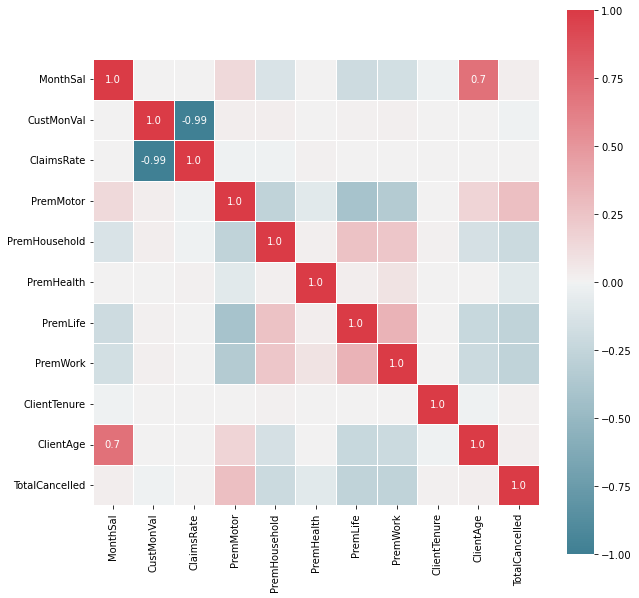

In [18]:
# builds correlation matrix
corre = round(data_exp[metric_features].corr(),2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corre.values) >= 0.5
annot = np.where(mask_annot, corre.values, np.full(corre.shape,"")) # Try to understand what this np.where() does

# Prepare figure
fig = plt.figure(figsize=(10, 10))
# Plot heatmap of the correlation matrix
sns.heatmap(data=corre, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

plt.show()

- Client age and Monthly salary are obviously correlated but I will still keep both
- Claims rate and customer value have a perfect correlation and are not really correlated with any variable else
- Client tenure is not correlated with any other variables
- Premium variables, MonthSal, Age and TotalCancelled are the variables kind of correlated with each other

In [29]:
## check the matrix
corre

,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,ClientTenure,ClientAge,TotalCancelled
MonthSal,1.00,-0.00,-0.00,0.14,-0.13,-0.00,-0.20,-0.17,-0.01,0.70,0.03
CustMonVal,-0.00,1.00,-0.99,0.03,0.03,0.00,0.01,0.02,-0.00,-0.00,-0.01
ClaimsRate,-0.00,-0.99,1.00,-0.01,-0.01,0.01,0.00,-0.00,0.00,-0.00,-0.00
PremMotor,0.14,0.03,-0.01,1.00,-0.27,-0.08,-0.41,-0.34,-0.00,0.16,0.28
PremHousehold,-0.13,0.03,-0.01,-0.27,1.00,0.02,0.26,0.24,0.01,-0.15,-0.21
PremHealth,-0.00,0.00,0.01,-0.08,0.02,1.00,0.03,0.08,-0.00,-0.00,-0.08
PremLife,-0.20,0.01,0.00,-0.41,0.26,0.03,1.00,0.34,0.00,-0.23,-0.27
PremWork,-0.17,0.02,-0.00,-0.34,0.24,0.08,0.34,1.00,0.00,-0.21,-0.27
ClientTenure,-0.01,-0.00,0.00,-0.00,0.01,-0.00,0.00,0.00,1.00,-0.01,0.01
ClientAge,0.70,-0.00,-0.00,0.16,-0.15,-0.00,-0.23,-0.21,-0.01,1.00,0.03


In [21]:
#data_exp.drop(['CustMonVal','ClaimsRate'], axis=1, inplace=True)

In [22]:
# # Prepare figure. Create individual axes where each histogram will be placed
# fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# # Plot data
# # Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
# for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
#     ax.hist(data_exp[feat])
#     ax.set_title(feat, y=-0.13)
    
# # Layout
# # Add a centered title to the figure:
# title = "Numeric Variables' Histograms"

# plt.suptitle(title)

# plt.savefig(os.path.join('..', 'figures', 'numeric_variables_histograms.png'), dpi=200)
# plt.show()

## Filtering outliers

The dataset has a lot of outliers. Lets do one feature at the time to analyze them.

In [15]:
data_exp[data_exp['ClientTenure']==-51768]

,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,ClientTenure,ClientAge,TotalCancelled,Cancelled
CustID,,,,,,,,,,,,,,,
9295.0,b'3 - BSc/MSc',3268.0,1.0,0.0,348.85,0.37,351.4,15.0,187.37,22.45,17.78,-51768.0,68.0,0,0


In [19]:
# because its only strange value for this variable and for this client, I will assume is an error and will be NaN
data_exp['ClientTenure'].replace(-51768, None, inplace=True)

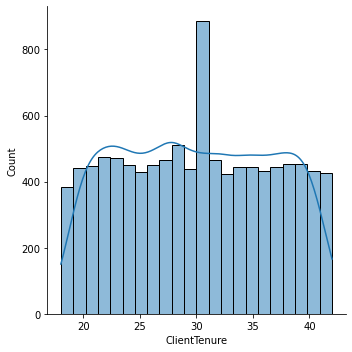

In [24]:
##plot client tenure
sns.displot(data= data_exp, x='ClientTenure', kde=True)
plt.show()

## there is a even distribution of tenures with a spik at 30 years of tenure. I would expect a more normal distribution

In [26]:
data_exp[data_exp['ClientAge']==988]

,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,ClientTenure,ClientAge,MotorCancelled,HomeCancelled,HealthCancelled,LifeCancelled,WorkCancelled,TotalCancelled,Cancelled
7195,b'3 - BSc/MSc',2830.0,4.0,0.0,146.02,0.77,428.97,192.8,108.91,1.89,23.67,23.0,988.0,0,0,0,0,0,0,0


In [20]:
# same logic as ClientTenure here for ClientAge
data_exp['ClientAge'].replace(988, None, inplace=True)

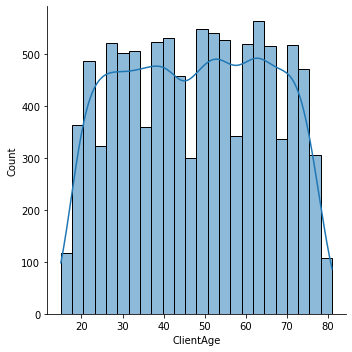

In [26]:
##plot client tenure
sns.displot(data= data_exp, x='ClientAge', kde=True)
plt.show()

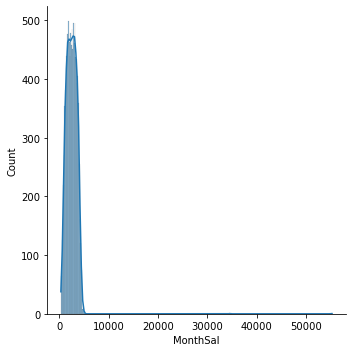

In [28]:
# Plot Monthly Salary
sns.displot(data= data_exp, x='MonthSal', kde=True)
plt.show()

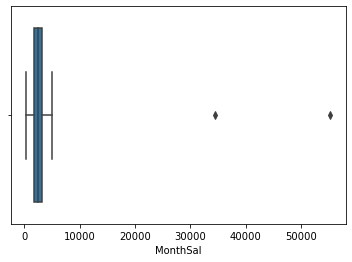

In [29]:
sns.boxplot(data= data_exp, x='MonthSal')
plt.show()

In [21]:
# Filter clients with a montly salary higher or equal to 3k - not losing the missings
data_exp = data_exp[(data_exp['MonthSal']<30000) | (data_exp['MonthSal'].isna())]

In [22]:
print('we kept {:.2f} of the original data'.format((len(data_exp)/(len(dataset)+3))*100))

we kept 99.95 of the original data


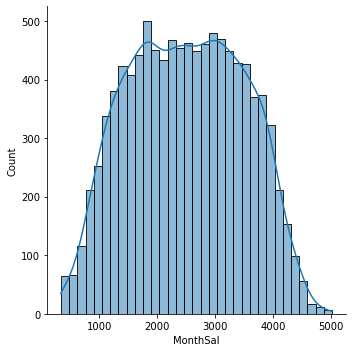

In [32]:
##plot monthly salary
sns.displot(data= data_exp, x='MonthSal', kde=True)
plt.show()

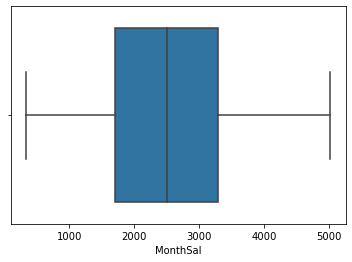

In [34]:
sns.boxplot(data= data_exp, x='MonthSal')
plt.show()

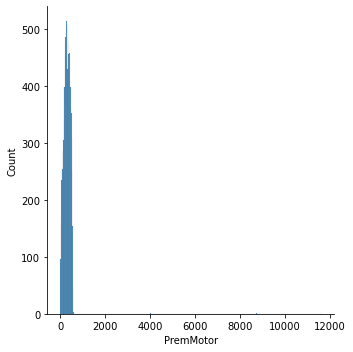

In [33]:
# Motor Premims
sns.displot(data=data_exp, x=data_exp['PremMotor'])
plt.show()

As we saw there is a client with 12k motor premium. Lets remove the client

In [36]:
# how many clients have a premium higher than 2k ?
data_exp[data_exp['PremMotor']>=2000] #7

,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,ClientTenure,ClientAge,MotorCancelled,HomeCancelled,HealthCancelled,LifeCancelled,WorkCancelled,TotalCancelled,Cancelled
5128,b'1 - Basic',3763.0,1.0,0.0,466.21,0.90,4003.44,612.9,137.36,121.69,31.34,20.0,73.0,0,0,0,0,0,0,0
5211,b'2 - High School',4135.0,3.0,0.0,130.14,0.99,8744.61,101.7,1767.00,155.14,130.58,35.0,73.0,0,0,0,0,0,0,0
5293,b'3 - BSc/MSc',3564.0,3.0,1.0,11875.89,0.09,11604.42,48.9,1045.52,103.13,296.47,27.0,53.0,0,0,0,0,0,0,0
6701,b'3 - BSc/MSc',2947.0,4.0,0.0,4328.50,0.03,4273.49,83.9,105.13,3.00,3.89,21.0,65.0,0,0,0,0,0,0,0
7085,b'3 - BSc/MSc',2460.0,3.0,1.0,5596.84,0.01,5645.50,0.0,49.01,1.89,1.89,24.0,53.0,0,1,0,0,0,1,1
7904,b'3 - BSc/MSc',2354.0,4.0,1.0,-46.89,1.01,3106.62,30.0,59.01,12.89,9.00,42.0,57.0,0,0,0,0,0,0,0


In [23]:
# Filter clients with a motor premium higher or equal to 2k
data_exp = data_exp[data_exp['PremMotor']<2000]

In [24]:
print('we kept {:.2f} of the original data'.format((len(data_exp)/(len(dataset)+3))*100))

we kept 99.89 of the original data


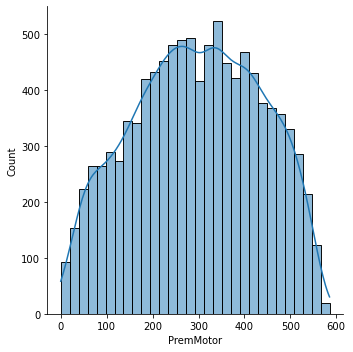

In [31]:
# Motor Premims
sns.displot(data=data_exp, x=data_exp['PremMotor'], kde=True)
plt.show()

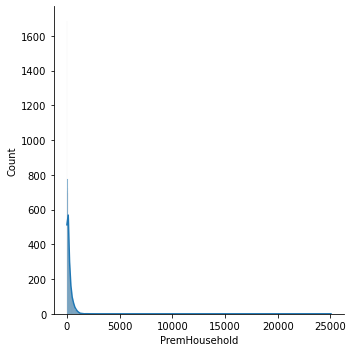

In [37]:
# Home Premims
sns.displot(data=data_exp, x=data_exp['PremHousehold'], kde=True)
plt.show()

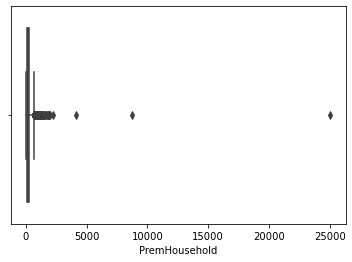

In [41]:
sns.boxplot(data= data_exp, x='PremHousehold')
plt.show()

In [38]:
# how many clients have a premium higher than 4k ?
data_exp[data_exp['PremHousehold']>=4000] #3

,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,ClientTenure,ClientAge,TotalCancelled,Cancelled
CustID,,,,,,,,,,,,,,,
6344.0,b'2 - High School',2642.0,2.0,1.0,0.78,0.99,424.19,4130.7,118.69,15.67,41.45,35.0,67.0,0,0
6836.0,b'3 - BSc/MSc',2832.0,4.0,1.0,-31.00,1.00,535.10,8762.8,41.12,0.00,9.78,41.0,50.0,1,1
8867.0,b'2 - High School',2618.0,4.0,1.0,473.54,0.98,508.43,25048.8,36.23,9.89,11.89,38.0,44.0,0,0


In [25]:
# Filter clients with a home premium higher or equal to 4k
data_exp = data_exp[data_exp['PremHousehold']<1500]

In [26]:
print('we kept {:.2f} of the original data'.format((len(data_exp)/(len(dataset)+3))*100))

we kept 99.76 of the original data


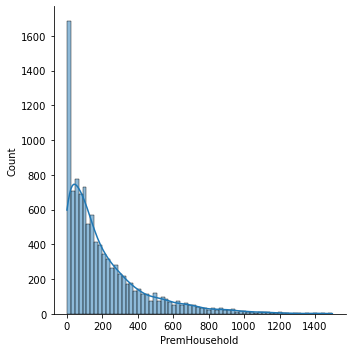

In [34]:
# Home Premims
sns.displot(data=data_exp, x=data_exp['PremHousehold'], kde=True)
plt.show()

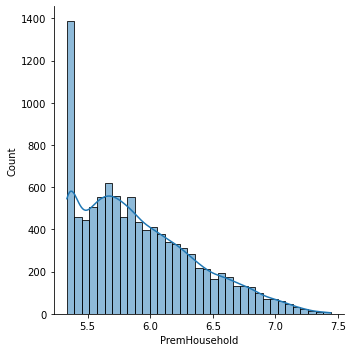

In [50]:
# Home Premims log transformation
sns.displot(data=data_exp, x=np.log(data_exp['PremHousehold']+data_exp['PremHousehold'].mean()), kde=True)
plt.show()

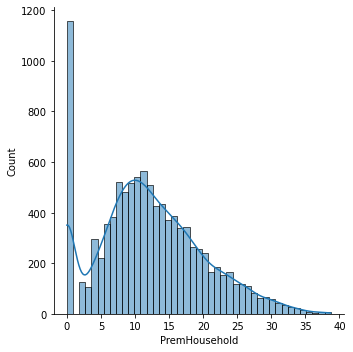

In [24]:
# Home Premims square root
sns.displot(data=data_exp, x=np.sqrt(data_exp['PremHousehold']), kde=True)
plt.show()

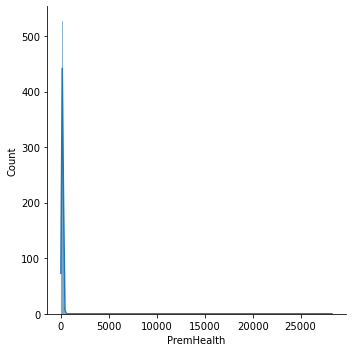

In [46]:
# Health Premims
sns.displot(data=data_exp, x=data_exp['PremHealth'], kde=True)
plt.show()

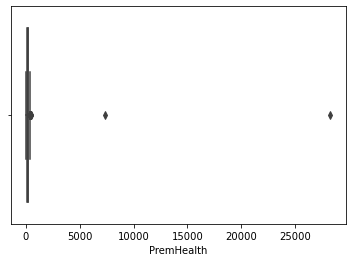

In [47]:
sns.boxplot(data= data_exp, x='PremHealth')
plt.show()

In [48]:
data_exp[data_exp['PremHealth']>5000]

,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,ClientTenure,ClientAge,MotorCancelled,HomeCancelled,HealthCancelled,LifeCancelled,WorkCancelled,TotalCancelled,Cancelled
7961,b'3 - BSc/MSc',4002.0,3.0,0.0,1457.99,0.83,431.86,107.80,7322.48,12.89,930.44,21.0,74.0,0,0,0,0,0,0,0
9149,b'2 - High School',987.0,3.0,1.0,804.05,0.97,26.34,829.05,28272.00,65.68,138.25,31.0,22.0,0,0,0,0,0,0,0


In [27]:
data_exp = data_exp[data_exp['PremHealth']<5000]

In [28]:
print('we kept {:.2f} of the original data'.format((len(data_exp)/(len(dataset)+3))*100))

we kept 99.74 of the original data


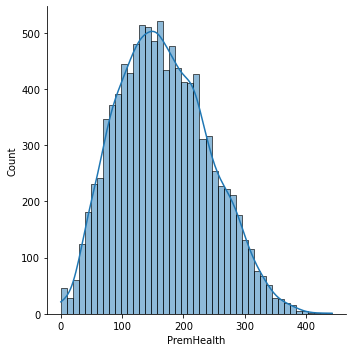

In [37]:
# Health Premims
sns.displot(data=data_exp, x=data_exp['PremHealth'], kde=True)
plt.show()

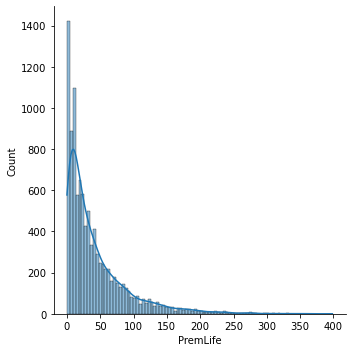

In [52]:
# Life Premims
sns.displot(data=data_exp, x=data_exp['PremLife'], kde=True)
plt.show()

In [29]:
data_exp = data_exp[data_exp['PremLife']<250]

In [30]:
print('we kept {:.2f} of the original data'.format((len(data_exp)/(len(dataset)+3))*100))

we kept 99.25 of the original data


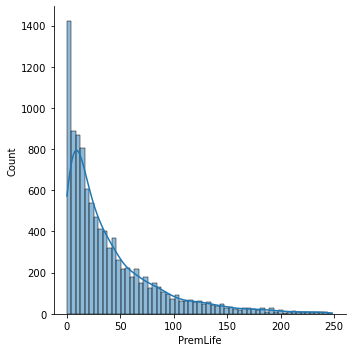

In [30]:
# Life Premims
sns.displot(data=data_exp, x=data_exp['PremLife'], kde=True)
plt.show()

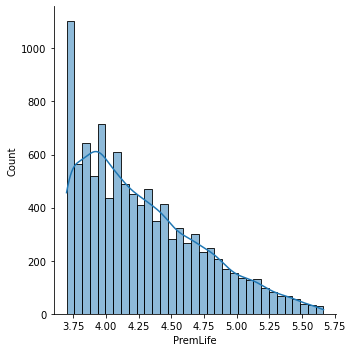

In [40]:
sns.displot(data=data_exp, x=np.log(data_exp['PremLife']+data_exp['PremLife'].mean()), kde=True)
plt.show()

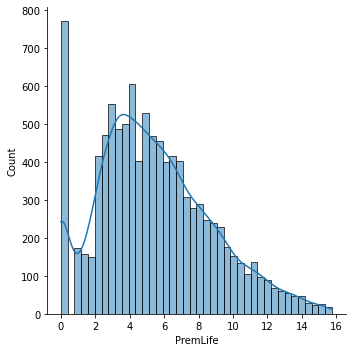

In [41]:
sns.displot(data=data_exp, x=np.sqrt(data_exp['PremLife']), kde=True)
plt.show()

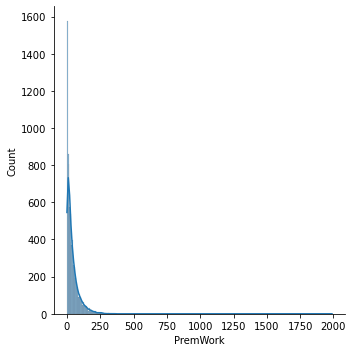

In [56]:
# Wokers Comp Premims
sns.displot(data=data_exp, x=data_exp['PremWork'], kde=True)
plt.show()

In [31]:
data_exp = data_exp[data_exp['PremWork']<300]

In [32]:
print('we kept {:.2f} of the original data'.format((len(data_exp)/(len(dataset)+3))*100))

we kept 99.10 of the original data


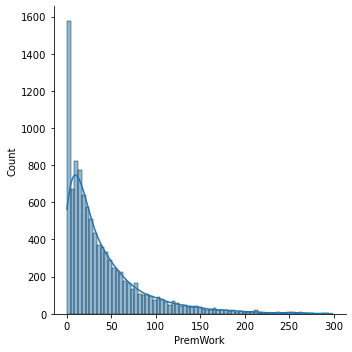

In [44]:
# Wokers Comp Premims
sns.displot(data=data_exp, x=data_exp['PremWork'], kde=True)
plt.show()

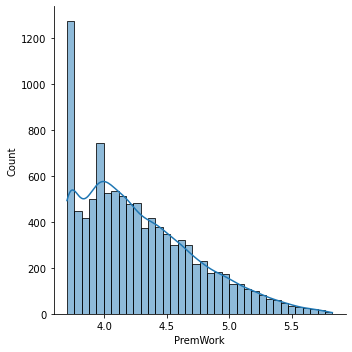

In [36]:
sns.displot(data=data_exp, x=np.log(data_exp['PremWork']+data_exp['PremWork'].mean()), kde=True)
plt.show()

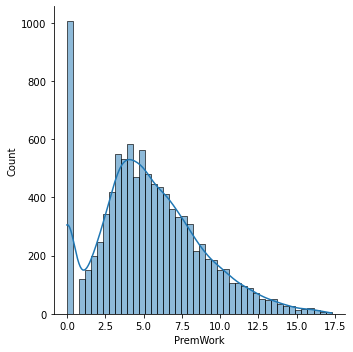

In [37]:
sns.displot(data=data_exp, x=np.sqrt(data_exp['PremWork']), kde=True)
plt.show()

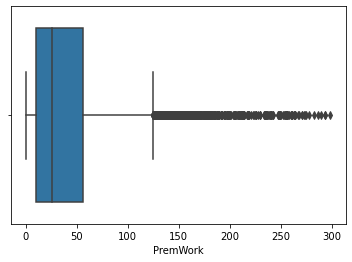

In [47]:
sns.boxplot(data= data_exp, x='PremWork')
plt.show()

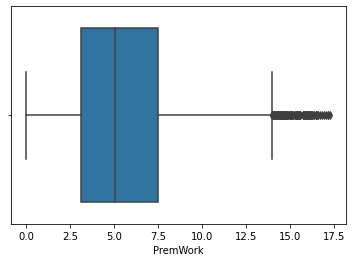

In [48]:
sns.boxplot(data= data_exp, x=np.sqrt(data_exp['PremWork']))
plt.show()


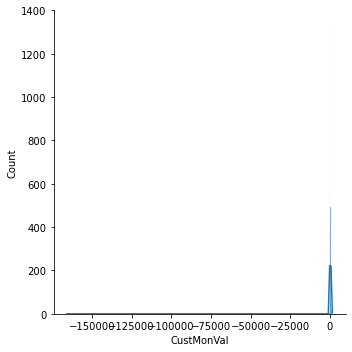

In [38]:
# Costumer Value
sns.displot(data=data_exp, x=data_exp['CustMonVal'], kde=True)
plt.show()

In [33]:
data_exp[data_exp['CustMonVal']<-2000]

,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,ClientTenure,ClientAge,TotalCancelled,Cancelled
CustID,,,,,,,,,,,,,,,
52.0,b'3 - BSc/MSc',3234.0,4.0,1.0,-14714.08,25.36,557.44,20.00,29.56,5.00,0.00,34.0,50.0,1,1
113.0,b'4 - PhD',2354.0,1.0,1.0,-8719.04,15.65,518.32,4.45,55.90,3.89,10.89,19.0,37.0,0,0
136.0,b'3 - BSc/MSc',2176.0,4.0,1.0,-10198.91,14.80,297.61,162.80,143.36,136.47,0.00,19.0,28.0,1,1
172.0,b'3 - BSc/MSc',1086.0,4.0,1.0,-165680.42,256.20,378.07,78.90,166.81,6.89,18.45,26.0,27.0,0,0
656.0,b'3 - BSc/MSc',3279.0,3.0,1.0,-64891.00,96.00,410.30,117.25,95.35,37.34,22.56,42.0,53.0,0,0
676.0,b'2 - High School',4435.0,1.0,0.0,-52382.76,63.00,197.48,280.60,276.94,51.12,38.34,22.0,79.0,0,0
708.0,b'3 - BSc/MSc',1634.0,1.0,1.0,-28945.40,35.00,175.70,319.50,294.39,44.12,16.89,25.0,25.0,0,0
759.0,b'3 - BSc/MSc',1117.0,1.0,1.0,-10107.37,12.60,193.37,342.85,276.94,8.78,47.23,28.0,24.0,0,0
794.0,b'3 - BSc/MSc',1370.0,3.0,1.0,-7851.17,13.90,127.58,48.35,398.41,19.56,12.78,36.0,33.0,0,0


In [34]:
data_exp = data_exp[data_exp['CustMonVal']>=-2000]

In [35]:
print('we kept {:.2f} of the original data'.format((len(data_exp)/(len(dataset)+3))*100))

we kept 98.96 of the original data


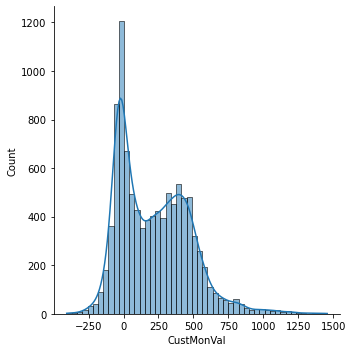

In [51]:
# Costumer Value
sns.displot(data=data_exp, x=data_exp['CustMonVal'], kde=True)
plt.show()

### Categorical variables

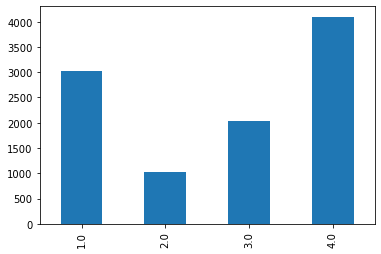

In [65]:
data_exp['GeoLivArea'].value_counts().sort_index().plot(kind='bar')
plt.show()

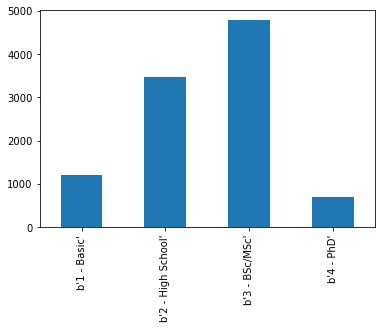

In [66]:
data_exp['EducDeg'].value_counts().sort_index().plot(kind='bar')
plt.show()

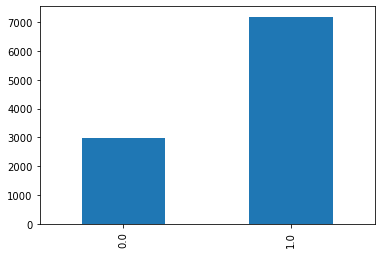

In [67]:
data_exp['Children'].value_counts().sort_index().plot(kind='bar')
plt.show()

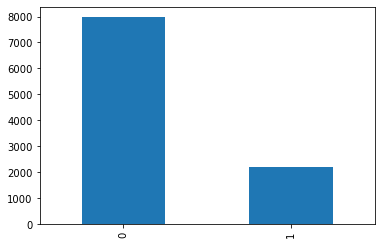

In [68]:
data_exp['Cancelled'].value_counts().sort_index().plot(kind='bar')
plt.show()

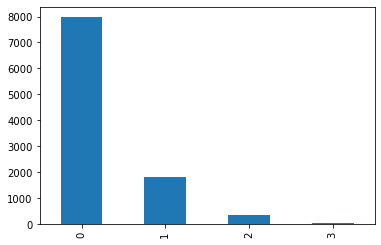

In [69]:
data_exp['TotalCancelled'].value_counts().sort_index().plot(kind='bar')
plt.show()

## 3) Data preprocessing

Lets take a look again to the data

In [46]:
data_exp[metric_features].describe().T

,count,mean,std,min,25%,50%,75%,max
MonthSal,10153.0,2508.012903,979.527183,333.00,1723.00,2513.00,3293.00,5021.00
CustMonVal,10189.0,216.775431,253.803244,-406.07,-9.22,186.27,398.08,1455.94
ClaimsRate,10189.0,0.680472,0.320094,0.00,0.39,0.72,0.98,4.33
PremMotor,10189.0,297.816492,137.790104,0.00,192.48,299.39,408.30,585.22
PremHousehold,10189.0,207.172755,226.585864,0.00,49.45,132.25,285.60,1498.05
PremHealth,10189.0,167.661381,74.765203,0.00,111.80,162.92,219.82,442.86
PremLife,10189.0,40.357309,43.950665,0.00,9.78,24.67,56.01,248.27
PremWork,10189.0,40.483303,44.810353,0.00,9.89,25.45,55.79,298.50
ClientTenure,10159.0,29.977458,6.608402,18.00,24.00,30.00,36.00,42.00
ClientAge,10172.0,48.087102,17.292986,15.00,33.00,48.00,63.00,81.00


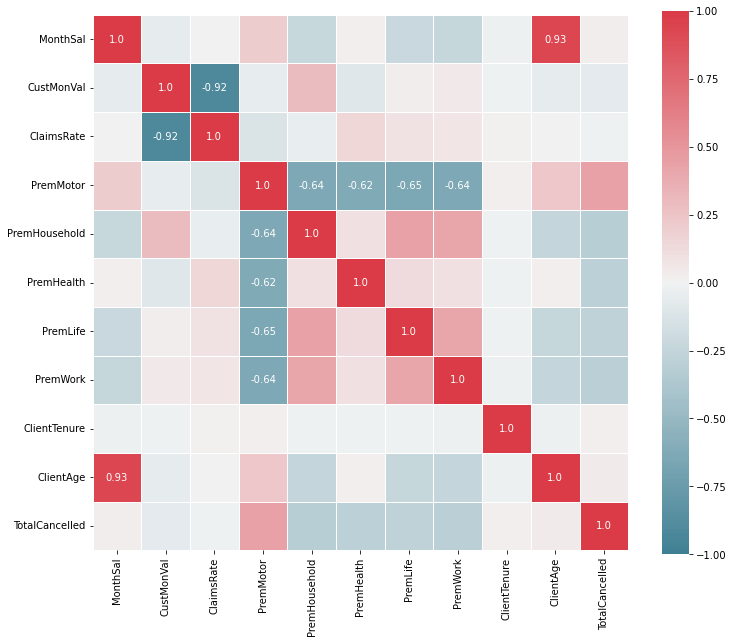

In [53]:
# builds correlation matrix
corre = round(data_exp[metric_features].corr(),2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corre.values) >= 0.5
annot = np.where(mask_annot, corre.values, np.full(corre.shape,"")) # Try to understand what this np.where() does

# Prepare figure
fig = plt.figure(figsize=(12, 10))
# Plot heatmap of the correlation matrix
sns.heatmap(data=corre, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

plt.show()

In [54]:
corre

,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,ClientTenure,ClientAge,TotalCancelled
MonthSal,1.00,-0.06,0.00,0.21,-0.23,0.02,-0.22,-0.24,-0.02,0.93,0.03
CustMonVal,-0.06,1.00,-0.92,-0.05,0.29,-0.10,0.03,0.05,-0.01,-0.06,-0.07
ClaimsRate,0.00,-0.92,1.00,-0.12,-0.04,0.15,0.09,0.07,0.01,0.00,-0.01
PremMotor,0.21,-0.05,-0.12,1.00,-0.64,-0.62,-0.65,-0.64,0.02,0.23,0.43
PremHousehold,-0.23,0.29,-0.04,-0.64,1.00,0.10,0.43,0.42,-0.01,-0.25,-0.32
PremHealth,0.02,-0.10,0.15,-0.62,0.10,1.00,0.12,0.10,-0.01,0.02,-0.29
PremLife,-0.22,0.03,0.09,-0.65,0.43,0.12,1.00,0.42,-0.01,-0.24,-0.28
PremWork,-0.24,0.05,0.07,-0.64,0.42,0.10,0.42,1.00,-0.02,-0.25,-0.30
ClientTenure,-0.02,-0.01,0.01,0.02,-0.01,-0.01,-0.01,-0.02,1.00,-0.02,0.02
ClientAge,0.93,-0.06,0.00,0.23,-0.25,0.02,-0.24,-0.25,-0.02,1.00,0.04


<b> Validating the data </b>

In [37]:
# Creating a new dataframe
data_prep = data_exp.copy()

In [56]:
# Clients where the client tenure is higher than their age
len(data_prep.loc[data_prep['ClientTenure']>data_prep['ClientAge']])

1927

In [57]:
round(len(data_prep.loc[data_prep['ClientTenure']>data_prep['ClientAge']])/len(data_prep),3)*100

18.9

~2k clients have a policy which is older than them. It represent 20% of the data 

- Age is very correlated with monthly salary. in montly salary I just have 36 missings. so I will keep MonthSal and drop ClientAge
- Age is in general more correlated with other variables (premium variables) than salary. that is obvious since age is used by insurance companies in their tariffs. younger customers generaly have higher premiums, not because they bring more value but because they represent a higher risk (more claims)
- Motor premiums have a great contribution for client TotalPremiums and very correlated with age. younger drivers have more claims on average
- So using age in my opinion will not compute meaningfull clusters

<b> Lets treat the rest of the missing data </b>

In [58]:
data_prep.isna().sum()

EducDeg           17
MonthSal          36
GeoLivArea         1
Children          21
CustMonVal         0
ClaimsRate         0
PremMotor          0
PremHousehold      0
PremHealth         0
PremLife           0
PremWork           0
ClientTenure      30
ClientAge         17
TotalCancelled     0
Cancelled          0
dtype: int64

I am thinking about creating a predictive model to estimate MonthSal to fill nan <br>
Possible explanatory variables = EducDeg, AgeClient, GeoLivArea, Children


In [74]:
# how many clients have MonthSal and ClientAge missing
print(len(data_prep[(data_prep.MonthSal.isna()) & (data_prep.ClientAge.isna())]))

0


In [75]:
# how many clients have MonthSal and EducDeg missing
print(len(data_prep[(data_prep.MonthSal.isna()) & (data_prep.EducDeg.isna())]))

1


In [76]:
# how many clients have MonthSal and GeoLivArea missing
print(len(data_prep[(data_prep.MonthSal.isna()) & (data_prep.GeoLivArea.isna())]))

0


In [77]:
# how many clients have MonthSal and GeoLivArea missing
print(len(data_prep[(data_prep.MonthSal.isna()) & (data_prep.Children.isna())]))

0


Only 1  client has EducDeg and MonthSal missing the rest of the clients are ok

In [38]:
# theres 1 client with GeoLivArea missing. I will not use this variable in my clusters but I will use to impute the other 
# variables so I will drop it
data_prep.dropna(subset=['EducDeg'], inplace=True)

In [39]:
print('we kept {:.2f} of the original data'.format((len(data_exp)/(len(dataset)+3))*100))

we kept 98.96 of the original data


In [47]:
# Monthly Salary
# I saw already that age is correlated with montly salary but maybe eductation level is too
# what is the average salary by education level
data_prep.groupby('EducDeg')['MonthSal'].median()

EducDeg
b'1 - Basic'          1794.5
b'2 - High School'    2508.5
b'3 - BSc/MSc'        2615.0
b'4 - PhD'            2645.0
Name: MonthSal, dtype: float64

- Higher degree greater the average salary

In [48]:
# Indeed we see that higher the education higher the monthly salary
# Also works for living area?
# what is the average salary by education level
data_prep.groupby('GeoLivArea')['MonthSal'].mean()

GeoLivArea
1.0    2481.500499
2.0    2564.571568
3.0    2494.657284
4.0    2517.537141
Name: MonthSal, dtype: float64

- living area 2 and 4 have higher average salaries compared with 1 and 3. but is it really different?

In [49]:
data_prep.groupby('Children')['MonthSal'].mean()

Children
0.0    3216.119771
1.0    2213.694911
Name: MonthSal, dtype: float64

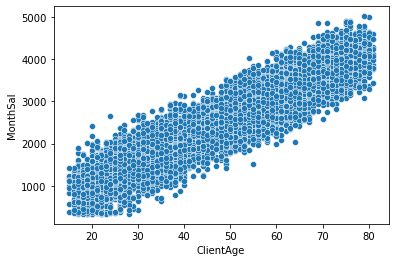

In [50]:
# relation between age and salary

sns.scatterplot(data=data_prep, x='ClientAge',y='MonthSal')
plt.show()

In [40]:
# I will try to predict clients monthly salary based on this 3 variables

# encoding level of education
data_prep['EducDeg'] = np.where(data_prep['EducDeg']==b'1 - Basic', 'Basic', data_prep['EducDeg'])
data_prep['EducDeg'] = np.where(data_prep['EducDeg']==b'2 - High School', 'HighSchool', data_prep['EducDeg'])
data_prep['EducDeg'] = np.where(data_prep['EducDeg']==b'3 - BSc/MSc', 'BscMsc', data_prep['EducDeg'])
data_prep['EducDeg'] = np.where(data_prep['EducDeg']==b'4 - PhD', 'PhD', data_prep['EducDeg'])

educ_dummys = pd.get_dummies(data_prep['EducDeg'], prefix='Educ')

In [41]:
educ_dummys.head()

,Educ_Basic,Educ_BscMsc,Educ_HighSchool,Educ_PhD
CustID,,,,
1.0,0,0,1,0
2.0,0,0,1,0
3.0,1,0,0,0
4.0,0,1,0,0
5.0,0,1,0,0


In [42]:
# I want to change the type to int and for that I need to impute the missing value since ints cannot have nan values
data_prep['GeoLivArea'].fillna(data_prep['GeoLivArea'].mode()[0], inplace=True)
data_prep['GeoLivArea'] = data_prep['GeoLivArea'].astype('int32')
liv_dummys = pd.get_dummies(data_prep['GeoLivArea'], prefix='LivArea')

In [43]:
liv_dummys.head()

,LivArea_1,LivArea_2,LivArea_3,LivArea_4
CustID,,,,
1.0,1,0,0,0
2.0,0,0,0,1
3.0,0,0,1,0
4.0,0,0,0,1
5.0,0,0,0,1


In [44]:
## merge the data
data_prep = pd.concat([data_prep,educ_dummys,liv_dummys], axis=1)
data_prep.head()

,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,...,TotalCancelled,Cancelled,Educ_Basic,Educ_BscMsc,Educ_HighSchool,Educ_PhD,LivArea_1,LivArea_2,LivArea_3,LivArea_4
CustID,,,,,,,,,,,,,,,,,,,,,
1.0,HighSchool,2177.0,1,1.0,380.97,0.39,375.85,79.45,146.36,47.01,...,0,0,0,0,1,0,1,0,0,0
2.0,HighSchool,677.0,4,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,...,0,0,0,0,1,0,0,0,0,1
3.0,Basic,2277.0,3,0.0,504.67,0.28,206.15,224.50,124.58,86.35,...,0,0,1,0,0,0,0,0,1,0
4.0,BscMsc,1099.0,4,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,...,0,0,0,1,0,0,0,0,0,1
5.0,BscMsc,1763.0,4,1.0,35.23,0.90,338.62,47.80,182.59,18.78,...,0,0,0,1,0,0,0,0,0,1


In [45]:
# to train the models I need to take the missings
ms_impute = data_prep.dropna()

In [46]:
# Predictig MonthSal 
features = ['ClientAge','Educ_Basic','Educ_HighSchool','Educ_BscMsc','Educ_PhD','LivArea_1','LivArea_2','LivArea_3','LivArea_4','Children']
X_train = ms_impute[features]
y_train = ms_impute.MonthSal

In [47]:
DecisionTree = DecisionTreeRegressor().fit(X_train,y_train)

In [92]:
# from sklearn import tree
# plt.figure(figsize=(50,50))
# tree.plot_tree(DecisionTree,feature_names=features, filled=True)
# plt.show()

In [48]:
print('R2 Score: {:.2f}'.format(metrics.r2_score(ms_impute.MonthSal, DecisionTree.predict(X_train))))
print('RMSE: {:.2f}'.format((metrics.mean_squared_error(ms_impute.MonthSal, DecisionTree.predict(X_train))**(1/2))))

R2 Score: 0.88
RMSE: 338.22


In [62]:
#LinearRegressor = LinearRegression().fit(X_train,y_train)

In [63]:
# print('R2 Score: {:.2f}'.format(metrics.r2_score(ms_impute.MonthSal, LinearRegressor.predict(X_train))))
# print('RMSE: {:.2f}'.format((metrics.mean_squared_error(ms_impute.MonthSal, LinearRegressor.predict(X_train))**(1/2))))

In [96]:
# RandomForest = RandomForestRegressor().fit(X_train,y_train)
# GradientBoost = GradientBoostingRegressor().fit(X_train,y_train)

In [97]:
# print('R2 Score: {:.2f}'.format(metrics.r2_score(ms_impute.MonthSal, RandomForest.predict(X_train))))
# print('RMSE: {:.2f}'.format((metrics.mean_squared_error(ms_impute.MonthSal, RandomForest.predict(X_train))**(1/2))))

R2 Score: 0.88
RMSE: 339.51


In [98]:
# print('R2 Score: {:.2f}'.format(metrics.r2_score(ms_impute.MonthSal, GradientBoost.predict(X_train))))
# print('RMSE: {:.2f}'.format((metrics.mean_squared_error(ms_impute.MonthSal, GradientBoost.predict(X_train))**(1/2))))

R2 Score: 0.86
RMSE: 364.79


In [49]:
# reset index for row iteration since we already drop some columns
data_prep.reset_index(inplace=True)

In [50]:
for i in range(len(data_prep)):
    if pd.isnull(data_prep.iloc[i]['MonthSal']) == True:
        data_prep['MonthSal'].iloc[i] = DecisionTree.predict(pd.DataFrame(data_prep.iloc[i][features]).T)[0]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [51]:
data_exp.loc[(data_exp['MonthSal'].isna()) & (data_exp['EducDeg'] == b'4 - PhD')]

,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,ClientTenure,ClientAge,TotalCancelled,Cancelled
CustID,,,,,,,,,,,,,,,
3228.0,b'4 - PhD',NaN,1.0,0.0,8.12,0.87,225.6,0.0,0.0,19.56,13.56,26.0,67.0,0,0


In [52]:
data_prep.loc[data_prep['CustID']==3228]

,CustID,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,...,TotalCancelled,Cancelled,Educ_Basic,Educ_BscMsc,Educ_HighSchool,Educ_PhD,LivArea_1,LivArea_2,LivArea_3,LivArea_4
3185,3228.0,PhD,3631.375,1,0.0,8.12,0.87,225.6,0.0,0.0,...,0,0,0,0,0,1,1,0,0,0


In [53]:
## impute discrete and categorical varibles with the mode
# these variables I will not use for clusters but only for interpretation

data_prep['ClientAge'].fillna(data_prep['ClientAge'].mode()[0],inplace=True)
data_prep['ClientTenure'].fillna(data_prep['ClientTenure'].mode()[0],inplace=True)
data_prep['EducDeg'].fillna(data_prep['EducDeg'].mode()[0],inplace=True)
data_prep['GeoLivArea'].fillna(data_prep['GeoLivArea'].mode()[0],inplace=True)
data_prep['Children'].fillna(data_prep['Children'].mode()[0],inplace=True)

In [54]:
# Creating new variables
data_prep['TotalPremiums'] = data_prep['PremMotor']+data_prep['PremHousehold']+data_prep['PremHealth']+data_prep['PremLife']+data_prep['PremWork']
#data_prep['ClaimsCost'] = data_prep['ClaimsRate'] * data_prep['TotalPremiums']
#data_prep['ClientMargin'] = data_prep['TotalPremiums']-data_prep['ClaimsCost']
data_prep['YearSal'] = data_prep['MonthSal']*14
data_prep['EffortRate'] = data_prep['TotalPremiums']/data_prep['YearSal']

## normalizing premium variables

data_prep['PremHousehold_Sqr'] = np.sqrt(data_prep['PremHousehold'])
data_prep['PremLife_Sqr'] = np.sqrt(data_prep['PremLife'])
data_prep['PremWork_Sqr'] = np.sqrt(data_prep['PremWork'])

In [55]:
data_prep.set_index('CustID', inplace=True)

In [56]:
data_prep.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 10172 entries, 1.0 to 10296.0
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   EducDeg            10172 non-null  object 
 1   MonthSal           10172 non-null  float64
 2   GeoLivArea         10172 non-null  int32  
 3   Children           10172 non-null  float64
 4   CustMonVal         10172 non-null  float64
 5   ClaimsRate         10172 non-null  float64
 6   PremMotor          10172 non-null  float64
 7   PremHousehold      10172 non-null  float64
 8   PremHealth         10172 non-null  float64
 9   PremLife           10172 non-null  float64
 10  PremWork           10172 non-null  float64
 11  ClientTenure       10172 non-null  float64
 12  ClientAge          10172 non-null  float64
 13  TotalCancelled     10172 non-null  int32  
 14  Cancelled          10172 non-null  int32  
 15  Educ_Basic         10172 non-null  uint8  
 16  Educ_BscMsc     

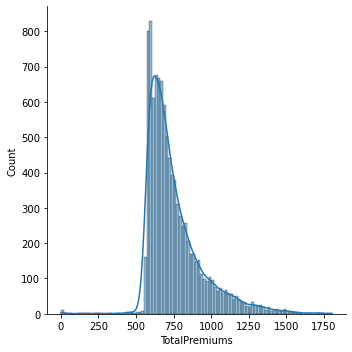

In [110]:
##plot Total premiums
sns.displot(data= data_prep, x='TotalPremiums', kde=True)
plt.show()

In [62]:
## There are customers with no premiums?
data_prep[data_prep['TotalPremiums']<100]

,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,...,LivArea_1,LivArea_2,LivArea_3,LivArea_4,TotalPremiums,YearSal,EffortRate,PremHousehold_Sqr,PremLife_Sqr,PremWork_Sqr
CustID,,,,,,,,,,,,,,,,,,,,,
5315.0,BscMsc,2924.0,4,1.0,-24.1,0.98,0.0,0.0,54.12,1.00,...,0,0,0,1,56.12,40936.0,0.001371,0.0,1.000000,1.000000
7963.0,PhD,1868.0,1,1.0,-56.1,4.33,0.0,0.0,0.00,12.89,...,1,0,0,0,24.89,26152.0,0.000952,0.0,3.590265,3.464102


In [57]:
data_prep = data_prep.loc[data_prep['TotalPremiums']>=100]

In [58]:
print('we kept {:.2f} of the original data'.format((len(data_prep)/(len(dataset)+3))*100))

we kept 98.66 of the original data


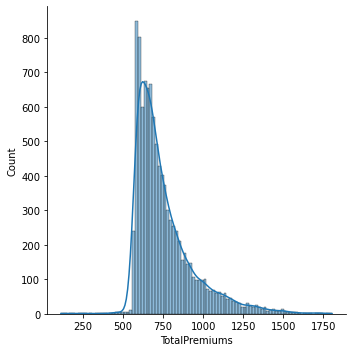

In [80]:
##plot Total premiums
sns.displot(data= data_prep, x='TotalPremiums', kde=True)
plt.show()

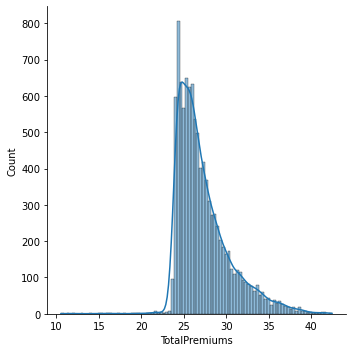

In [84]:
##plot Total premiums
sns.displot(data= data_prep, x=np.sqrt(data_prep['TotalPremiums']), kde=True)
plt.show()

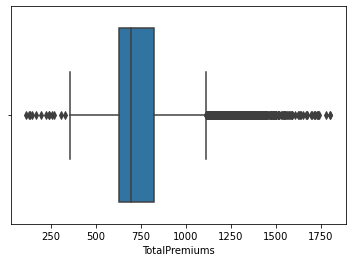

In [66]:
sns.boxplot(data= data_prep, x='TotalPremiums')
plt.show()

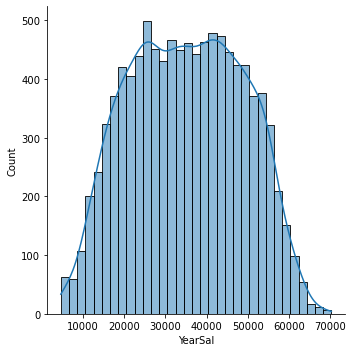

In [106]:
##plot Yearl Salary
sns.displot(data= data_prep, x='YearSal', kde=True)
plt.show()

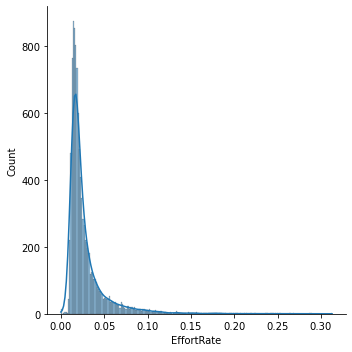

In [113]:
##plot effort rate
sns.displot(data= data_prep, x='EffortRate', kde=True)
plt.show()

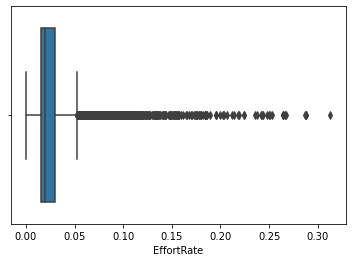

In [114]:
sns.boxplot(data=data_prep, x='EffortRate')
plt.show()

In [59]:
data_prep = data_prep[(data_prep['EffortRate']<=0.2) | (data_prep['EffortRate'].isna())]

In [60]:
print('we kept {:.2f} of the original data'.format((len(data_prep)/(len(dataset)+3))*100))

we kept 98.39 of the original data


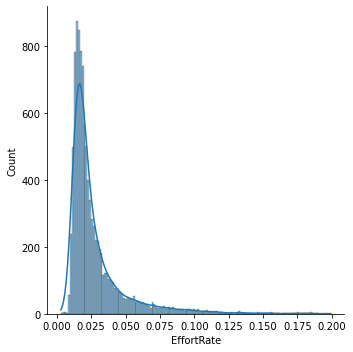

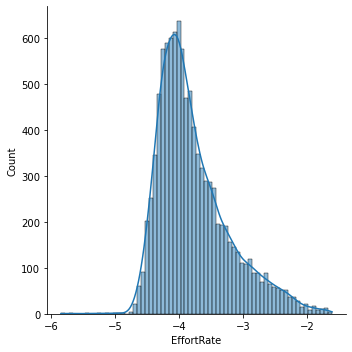

In [73]:
##plot effort rate
sns.displot(data= data_prep, x='EffortRate', kde=True)
plt.show()
sns.displot(data= data_prep, x=np.log(data_prep['EffortRate']), kde=True)
plt.show()

In [61]:
data_prep['EffortRate_log'] = np.log(data_prep['EffortRate'])

In [62]:
# add new variables to metric features
metric_features = metric_features+['TotalPremiums','YearSal','EffortRate','EffortRate_log','PremHousehold_Sqr','PremLife_Sqr','PremWork_Sqr']

In [63]:
metric_features

['MonthSal',
 'CustMonVal',
 'ClaimsRate',
 'PremMotor',
 'PremHousehold',
 'PremHealth',
 'PremLife',
 'PremWork',
 'ClientTenure',
 'ClientAge',
 'TotalCancelled',
 'TotalPremiums',
 'YearSal',
 'EffortRate',
 'EffortRate_log',
 'PremHousehold_Sqr',
 'PremLife_Sqr',
 'PremWork_Sqr']

In [64]:
print(data_prep.shape)

(10130, 30)


In [65]:
## create new variables

## client has specific LoB

data_prep['HasMotor'] = np.where(data_prep['PremMotor']>0,1,0)
data_prep['HasHome'] = np.where(data_prep['PremHousehold']>0,1,0)
data_prep['HasHealth'] = np.where(data_prep['PremHealth']>0,1,0)
data_prep['HasLife'] = np.where(data_prep['PremLife']>0,1,0)
data_prep['HasWork'] = np.where(data_prep['PremWork']>0,1,0)

## total number of LoB
data_prep['NumberProducts'] = data_prep['HasMotor']+data_prep['HasHome']+data_prep['HasHealth']+data_prep['HasLife']+data_prep['HasWork']

## is the client multi-product

#data_prep['IsEquiped'] = np.where(data_prep['NumberProducts']>1,1,0)

# average premium
# data_prep['AveragePremium'] = data_prep['TotalPremiums']/data_prep['NumberProducts']

## proportions of products

# data_prep['ProdMotorProp'] = data_prep['HasMotor']/data_prep['NumberProducts']
# data_prep['ProdHouseholdProp'] = data_prep['HasHome']/data_prep['NumberProducts']
# data_prep['ProdHealthProp'] = data_prep['HasHealth']/data_prep['NumberProducts']
# data_prep['ProdLifeProp'] = data_prep['HasLife']/data_prep['NumberProducts']
# data_prep['ProdWorkProp'] = data_prep['HasWork']/data_prep['NumberProducts']

## proportions of premiums

# data_prep['PremMotorProp'] = data_prep['PremMotor']/data_prep['TotalPremiums']
# data_prep['PremHouseholdProp'] = data_prep['PremHousehold']/data_prep['TotalPremiums']
# data_prep['PremHealthProp'] = data_prep['PremHealth']/data_prep['TotalPremiums']
# data_prep['PremLifeProp'] = data_prep['PremLife']/data_prep['TotalPremiums']
# data_prep['PremWorkProp'] = data_prep['PremWork']/data_prep['TotalPremiums']

In [126]:
# data_prep = data_prep.loc[data_prep['NumberProducts']>0]

In [127]:
# print('we kept {:.2f} of the original data'.format((len(data_prep)/(len(dataset)+3))*100))

we kept 98.41 of the original data


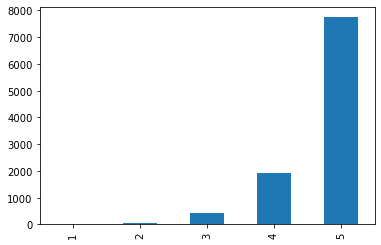

In [66]:
data_prep['NumberProducts'].value_counts().sort_index().plot(kind='bar')
plt.show()

In [92]:
data_prep.NumberProducts.value_counts(normalize=True)

5    0.763475
4    0.189437
3    0.041165
2    0.005824
1    0.000099
Name: NumberProducts, dtype: float64

In [81]:
data_prep.NumberProducts.value_counts(normalize=False)

5    7734
4    1919
3     417
2      59
1       1
Name: NumberProducts, dtype: int64

In [67]:
## aggregate number of products
data_prep['NumberProducts'] = np.where(data_prep['NumberProducts'] < 4, 3, data_prep['NumberProducts'])

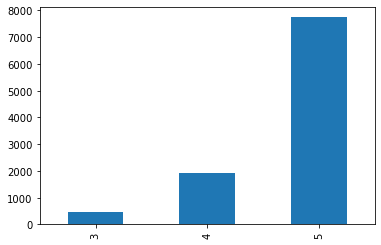

In [68]:
data_prep['NumberProducts'].value_counts().sort_index().plot(kind='bar')
plt.show()

In [69]:
# add new variables to metric features
metric_features = metric_features+['NumberProducts']

## Applying Clustering

In [70]:
data_prep.drop('MonthSal', axis=1, inplace=True)

In [71]:
# removes MonthSal from the list
metric_features = metric_features[1:]

In [72]:
metric_features

['CustMonVal',
 'ClaimsRate',
 'PremMotor',
 'PremHousehold',
 'PremHealth',
 'PremLife',
 'PremWork',
 'ClientTenure',
 'ClientAge',
 'TotalCancelled',
 'TotalPremiums',
 'YearSal',
 'EffortRate',
 'EffortRate_log',
 'PremHousehold_Sqr',
 'PremLife_Sqr',
 'PremWork_Sqr',
 'NumberProducts']

In [90]:
# metric_features.remove('ClaimsRate')
# metric_features

In [102]:
df_train = data_prep.copy()

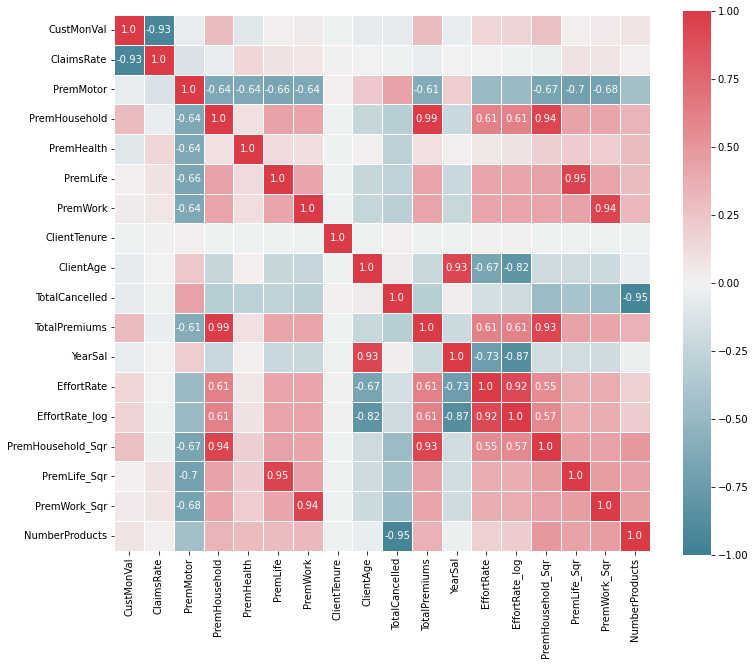

In [101]:
# builds correlation matrix
corre = round(df_train[metric_features].corr(),2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corre.values) >= 0.5
annot = np.where(mask_annot, corre.values, np.full(corre.shape,"")) # Try to understand what this np.where() does

# Prepare figure
fig = plt.figure(figsize=(12, 10))
# Plot heatmap of the correlation matrix
sns.heatmap(data=corre, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

plt.show()

In [102]:
corre

,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,ClientTenure,ClientAge,TotalCancelled,TotalPremiums,YearSal,EffortRate,EffortRate_log,PremHousehold_Sqr,PremLife_Sqr,PremWork_Sqr,NumberProducts
CustMonVal,1.00,-0.93,-0.05,0.29,-0.10,0.02,0.04,-0.01,-0.06,-0.07,0.29,-0.05,0.15,0.16,0.27,0.02,0.05,0.08
ClaimsRate,-0.93,1.00,-0.13,-0.04,0.15,0.09,0.07,0.01,0.00,-0.02,-0.04,0.00,0.00,-0.01,-0.03,0.09,0.08,0.02
PremMotor,-0.05,-0.13,1.00,-0.64,-0.64,-0.66,-0.64,0.02,0.23,0.44,-0.61,0.20,-0.49,-0.49,-0.67,-0.70,-0.68,-0.43
PremHousehold,0.29,-0.04,-0.64,1.00,0.10,0.43,0.41,-0.01,-0.24,-0.32,0.99,-0.22,0.61,0.61,0.94,0.43,0.42,0.33
PremHealth,-0.10,0.15,-0.64,0.10,1.00,0.12,0.11,-0.01,0.02,-0.29,0.10,0.02,0.06,0.09,0.19,0.21,0.20,0.30
PremLife,0.02,0.09,-0.66,0.43,0.12,1.00,0.41,-0.01,-0.24,-0.28,0.42,-0.22,0.41,0.41,0.43,0.95,0.42,0.29
PremWork,0.04,0.07,-0.64,0.41,0.11,0.41,1.00,-0.02,-0.25,-0.30,0.41,-0.23,0.42,0.41,0.41,0.43,0.94,0.31
ClientTenure,-0.01,0.01,0.02,-0.01,-0.01,-0.01,-0.02,1.00,-0.02,0.02,-0.01,-0.02,0.01,0.01,-0.01,-0.02,-0.02,-0.02
ClientAge,-0.06,0.00,0.23,-0.24,0.02,-0.24,-0.25,-0.02,1.00,0.04,-0.23,0.93,-0.67,-0.82,-0.20,-0.19,-0.21,-0.04
TotalCancelled,-0.07,-0.02,0.44,-0.32,-0.29,-0.28,-0.30,0.02,0.04,1.00,-0.32,0.03,-0.17,-0.20,-0.48,-0.41,-0.45,-0.95


In [103]:
df_train[metric_features].isna().sum()

CustMonVal           0
ClaimsRate           0
PremMotor            0
PremHousehold        0
PremHealth           0
PremLife             0
PremWork             0
ClientTenure         0
ClientAge            0
TotalCancelled       0
TotalPremiums        0
YearSal              0
EffortRate           0
EffortRate_log       0
PremHousehold_Sqr    0
PremLife_Sqr         0
PremWork_Sqr         0
NumberProducts       0
dtype: int64

In [103]:
df_train_scaled = df_train.copy()
scaler = StandardScaler()
scaler.fit(df_train_scaled[metric_features])
df_train_scaled[metric_features] = scaler.transform(df_train[metric_features])

In [104]:
df_train_scaled.head()

,EducDeg,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,...,PremHousehold_Sqr,PremLife_Sqr,PremWork_Sqr,EffortRate_log,HasMotor,HasHome,HasHealth,HasLife,HasWork,NumberProducts
CustID,,,,,,,,,,,,,,,,,,,,,
1.0,HighSchool,1,1.0,0.650840,-0.917857,0.561845,-0.563568,-0.289965,0.154750,-0.525368,...,-0.416495,0.436533,-0.379527,-0.084087,1,1,1,1,1,0.520104
2.0,HighSchool,4,1.0,-1.375483,1.383616,-1.615691,0.938658,-0.687918,3.523153,1.474365,...,1.078534,2.580009,1.460972,2.584752,1,1,1,1,1,0.520104
3.0,Basic,3,0.0,1.140308,-1.264654,-0.676561,0.083493,-0.582092,1.053326,1.315040,...,0.373459,1.173101,1.356626,0.027430,1,1,1,1,1,0.520104
4.0,BscMsc,4,1.0,-0.923843,0.973765,-0.849295,-0.724608,1.920574,-0.111807,-0.268791,...,-0.719653,0.160893,-0.018754,0.962234,1,1,1,1,1,0.520104
5.0,BscMsc,4,1.0,-0.717215,0.690022,0.290155,-0.704757,0.195975,-0.490059,0.024984,...,-0.676746,-0.326251,0.312547,0.194728,1,1,1,1,1,0.520104


Start applying alghoritms.

### Product Segmentation

In [105]:
product_features = ['PremMotor','PremHousehold_Sqr','PremHealth','PremLife_Sqr','PremWork_Sqr']

In [176]:
df_product = df_train_scaled[product_features]

In [177]:
df_product.head()

,PremMotor,PremHousehold_Sqr,PremHealth,PremLife_Sqr,PremWork_Sqr
CustID,,,,,
1.0,0.561845,-0.416495,-0.289965,0.436533,-0.379527
2.0,-1.615691,1.078534,-0.687918,2.580009,1.460972
3.0,-0.676561,0.373459,-0.582092,1.173101,1.356626
4.0,-0.849295,-0.719653,1.920574,0.160893,-0.018754
5.0,0.290155,-0.676746,0.195975,-0.326251,0.312547


In [108]:
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_product)
    sse.append(kmeans.inertia_)

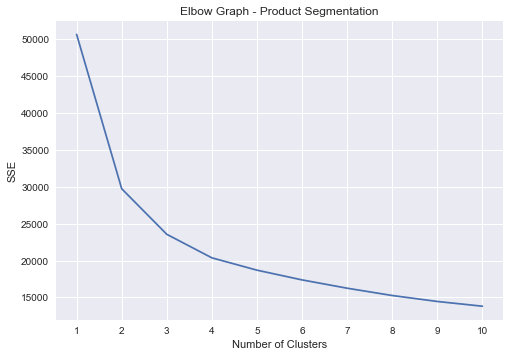

In [109]:
plt.style.use("seaborn")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.title('Elbow Graph - Product Segmentation')
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

Looks like its 3 but lets confirm:

In [178]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

4

In [179]:
kmeans_product = KMeans(init="random", n_clusters=4, n_init=20, max_iter=300,random_state=42).fit(df_product)

In [180]:
kmeans_product.feature_names_in_

array(['PremMotor', 'PremHousehold_Sqr', 'PremHealth', 'PremLife_Sqr',
       'PremWork_Sqr'], dtype=object)

In [181]:
cluster_product = pd.Series(kmeans_product.labels_, name='ClusterID_Product', index=df_product.index)

In [ ]:
# # A list holds the silhouette coefficients for each k
# silhouette_coefficients = []

# # Notice you start at 2 clusters for silhouette coefficient
# for k in range(2, 10):
#     kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
#     kmeans.fit(df_train2)
#     score = silhouette_score(df_train2, kmeans.labels_)
#     silhouette_coefficients.append(score)

In [ ]:
# plt.style.use("seaborn")
# plt.plot(range(2, 10), silhouette_coefficients)
# plt.xticks(range(2, 10))
# plt.title("Silhouette Graph")
# plt.xlabel("Number of Clusters")
# plt.ylabel("Silhouette Coefficient")
# plt.show()

In [182]:
# The lowest SSE value
kmeans_product.inertia_

20371.016668455737

In [183]:
# Final locations of the centroid
kmeans_product.cluster_centers_

array([[ 1.25871309, -0.89497907, -1.0307299 , -0.90908256, -0.88255457],
       [-0.78855599,  0.1868915 ,  1.30019877,  0.22588145,  0.21999787],
       [ 0.27361741, -0.14786956, -0.03772681, -0.16156954, -0.16329184],
       [-1.18633103,  1.21872155, -0.14803686,  1.21359709,  1.18842727]])

In [184]:
# The number of iterations required to converge
kmeans_product.n_iter_

11

In [185]:
# from scipy import stats
np.unique(kmeans_product.labels_, return_counts=True)

(array([0, 1, 2, 3]), array([2557, 2341, 3313, 1919], dtype=int64))

In [186]:
## adding the cluster to the dataframe
df_product = pd.concat([df_product, cluster_product], axis=1)

In [187]:
df_product.groupby('ClusterID_Product')[product_features].agg('mean')

,PremMotor,PremHousehold_Sqr,PremHealth,PremLife_Sqr,PremWork_Sqr
ClusterID_Product,,,,,
0,1.258573,-0.894872,-1.030590,-0.908705,-0.882468
1,-0.787650,0.184394,1.300417,0.225668,0.219444
2,0.273330,-0.146967,-0.038659,-0.160848,-0.161962
3,-1.188027,1.221168,-0.146420,1.213215,1.187770


In [188]:
product_centroids = df_product.groupby('ClusterID_Product', as_index=False)[product_features].agg('mean')

<AxesSubplot:>

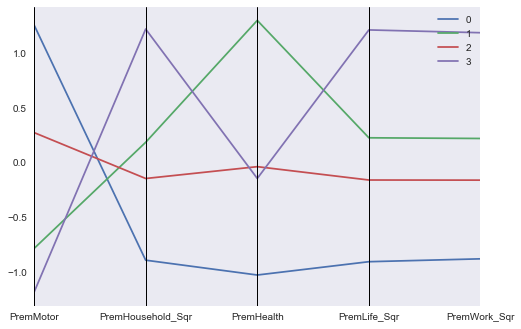

In [189]:
pd.plotting.parallel_coordinates(product_centroids, 'ClusterID_Product', color=sns.color_palette())

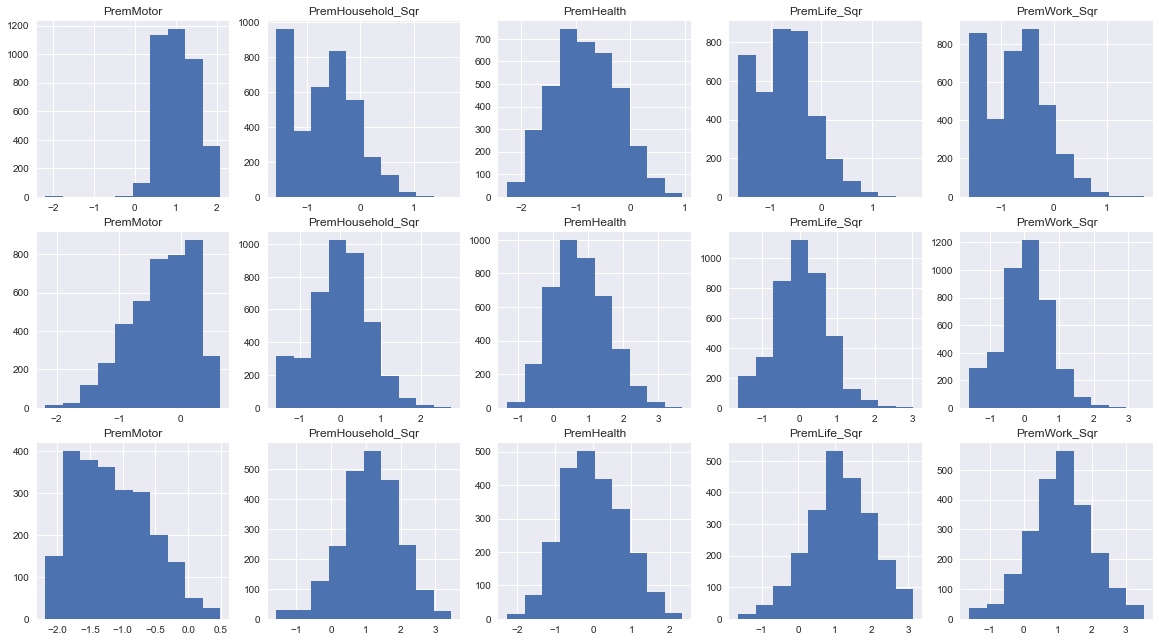

In [122]:
#
clusters = [0,0,0,0,0,1,1,1,1,1,2,2,2,2,2]
features = product_features+product_features+product_features

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(3, 5, figsize=(20, 11))
# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat, k in zip(axes.flatten(), features, clusters): # Notice the zip() function and flatten() method
    ax.hist(df_product.loc[df_product['ClusterID_Product']== k,feat])
    ax.set_title(feat, y=1)
    
# # Layout
# # Add a centered title to the figure:
# title = "Numeric Variables' Histograms"

# plt.suptitle(title)

# plt.savefig(os.path.join('..', 'figures', 'numeric_variables_histograms.png'), dpi=200)
# plt.show()

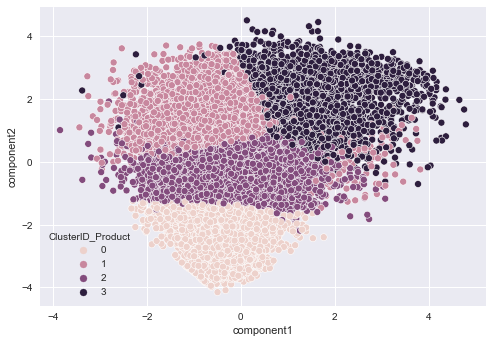

In [191]:
# Visualiziting the clusters with MDS

embedding = MDS(n_components=2)
mds = pd.DataFrame(embedding.fit_transform(df_product.drop('ClusterID_Product',axis=1)),
             columns = ['component1','component2'])

mds['ClusterID_Product'] = kmeans_product.predict(df_product.drop('ClusterID_Product',axis=1))

sns.scatterplot(data=mds,x = "component1",y="component2",hue="ClusterID_Product")
plt.show()

### Value Segmentation

In [123]:
value_features = ['TotalPremiums','CustMonVal','EffortRate_log','NumberProducts']

In [124]:
df_value = df_train_scaled[value_features]

In [125]:
df_value.head()

,TotalPremiums,CustMonVal,EffortRate_log,NumberProducts
CustID,,,,
1.0,-0.480713,0.650840,-0.084087,0.520104
2.0,0.865448,-1.375483,2.584752,0.520104
3.0,-0.069075,1.140308,0.027430,0.520104
4.0,-0.836617,-0.923843,0.962234,0.520104
5.0,-0.679949,-0.717215,0.194728,0.520104


In [126]:
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_value)
    sse.append(kmeans.inertia_)

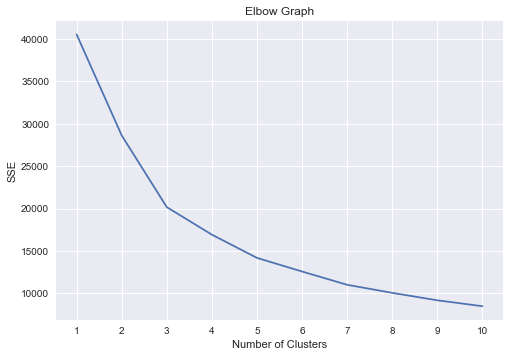

In [127]:
# Plot Elbow graphic
plt.style.use("seaborn")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.title('Elbow Graph')
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [128]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

3

In [129]:
kmeans_value = KMeans(init="random", n_clusters=3, n_init=20, max_iter=300,random_state=42)

In [130]:
kmeans_value.fit(df_value)

KMeans(init='random', n_clusters=3, n_init=20, random_state=42)

In [131]:
# from scipy import stats
np.unique(kmeans_value.labels_, return_counts=True)

(array([0, 1, 2]), array([1755, 6062, 2313], dtype=int64))

In [132]:
cluster_value = pd.Series(kmeans_value.labels_,name='ClusterID_value', index=df_value.index)

In [133]:
## adding the cluster to the dataframe
df_value = pd.concat([df_value, cluster_value], axis=1)

In [134]:
df_value.head()

,TotalPremiums,CustMonVal,EffortRate_log,NumberProducts,ClusterID_value
CustID,,,,,
1.0,-0.480713,0.650840,-0.084087,0.520104,1
2.0,0.865448,-1.375483,2.584752,0.520104,0
3.0,-0.069075,1.140308,0.027430,0.520104,1
4.0,-0.836617,-0.923843,0.962234,0.520104,1
5.0,-0.679949,-0.717215,0.194728,0.520104,1


In [135]:
df_value.groupby('ClusterID_value')[value_features].agg('mean')

,TotalPremiums,CustMonVal,EffortRate_log,NumberProducts
ClusterID_value,,,,
0,1.629454,0.663859,1.488796,0.433375
1,-0.202571,-0.127850,-0.260624,0.520104
2,-0.705451,-0.168631,-0.446578,-1.691935


In [136]:
value_centroids = df_value.groupby('ClusterID_value', as_index=False)[value_features].agg('mean')

<AxesSubplot:>

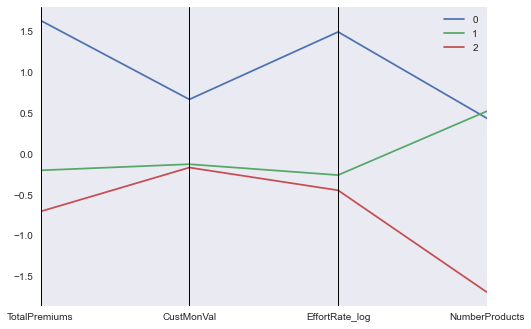

In [137]:
pd.plotting.parallel_coordinates(value_centroids, 'ClusterID_value', color=sns.color_palette())

In [138]:
## try again taking out NumberProducts

df_value.drop(columns=['ClusterID_value','NumberProducts'], inplace=True)

In [139]:
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_value)
    sse.append(kmeans.inertia_)

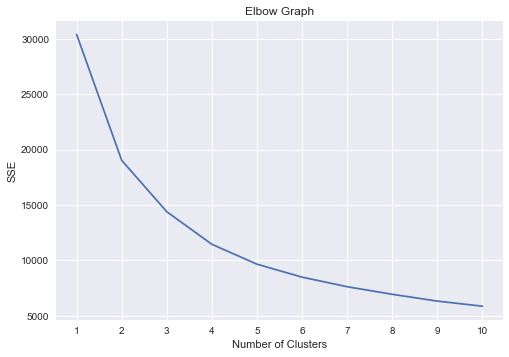

In [140]:
plt.style.use("seaborn")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.title('Elbow Graph')
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [141]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

4

In [142]:
kmeans_value = KMeans(init="random", n_clusters=4, n_init=20, max_iter=300,random_state=42)

In [143]:
kmeans_value.fit(df_value)

KMeans(init='random', n_clusters=4, n_init=20, random_state=42)

In [144]:
np.unique(kmeans_value.labels_, return_counts=True)

(array([0, 1, 2, 3]), array([ 615, 1656, 3834, 4025], dtype=int64))

In [145]:
cluster_value = pd.Series(kmeans_value.labels_,name='ClusterID_value', index=df_value.index)

In [146]:
## adding the cluster to the dataframe
df_value = pd.concat([df_value, cluster_value], axis=1)

In [148]:
value_features.remove('NumberProducts')
df_value.groupby('ClusterID_value')[value_features].agg('mean')

,TotalPremiums,CustMonVal,EffortRate_log
ClusterID_value,,,
0,2.130398,2.112368,1.522142
1,0.979761,-0.439248,1.343252
2,-0.270536,0.708707,-0.343224
3,-0.470918,-0.817117,-0.458291


In [149]:
value_centroids = df_value.groupby('ClusterID_value', as_index=False)[value_features].agg('mean')

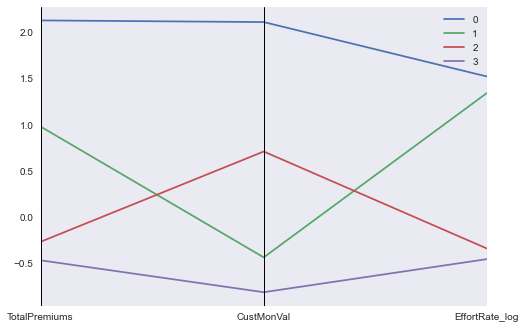

In [151]:
pd.plotting.parallel_coordinates(value_centroids, 'ClusterID_value', color=sns.color_palette())
plt.show()

In [152]:
## try only with TotalPremiums and CustMonVal
df_value.drop(columns=['ClusterID_value','EffortRate_log'], inplace=True)

In [153]:
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_value)
    sse.append(kmeans.inertia_)

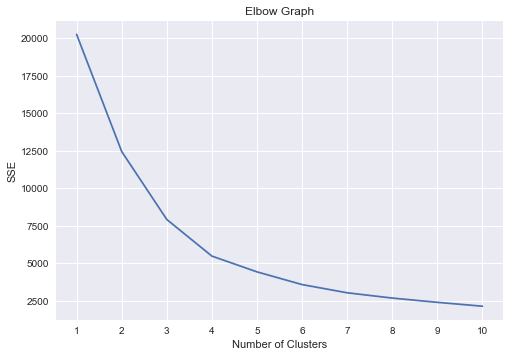

In [154]:
plt.style.use("seaborn")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.title('Elbow Graph')
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [155]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

4

In [156]:
kmeans_value.fit(df_value)

KMeans(init='random', n_clusters=4, n_init=20, random_state=42)

In [157]:
np.unique(kmeans_value.labels_, return_counts=True)

(array([0, 1, 2, 3]), array([4270, 4151,  994,  715], dtype=int64))

In [158]:
cluster_value = pd.Series(kmeans_value.labels_,name='ClusterID_value', index=df_value.index)

In [159]:
## adding the cluster to the dataframe
df_value = pd.concat([df_value, cluster_value], axis=1)

In [160]:
value_features.remove('EffortRate_log')
df_value.groupby('ClusterID_value')[value_features].agg('mean')

,TotalPremiums,CustMonVal
ClusterID_value,,
0,-0.455286,-0.824428
1,-0.269180,0.648630
2,1.692530,-0.645586
3,1.928761,2.055323


In [162]:
value_centroids = df_value.groupby('ClusterID_value', as_index=False)[value_features].agg('mean')

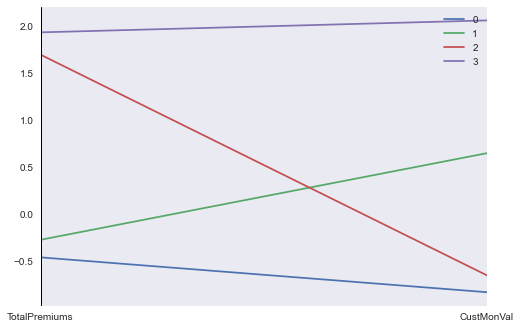

In [163]:
pd.plotting.parallel_coordinates(value_centroids, 'ClusterID_value', color=sns.color_palette())
plt.show()

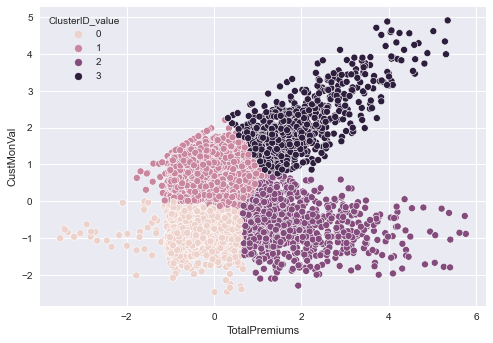

In [167]:
sns.scatterplot(data=df_value, x='TotalPremiums', y='CustMonVal', hue='ClusterID_value')
plt.show()